# Описание задачи

* Нужно на основе данных предсказать рейтинг шоколада.
* аккаунт kaggle - andreipoluesov

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import requests


# Импорт библиотек
import requests as rq
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython import display

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer, power_transform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import warnings

import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from pymystem3 import Mystem
from scipy.sparse import coo_matrix, hstack

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Предобработка данных

In [2]:
test = pd.read_csv('/Users/andrejglavniy/Downloads/practical-ml-chocolate/chocolate_test_new.csv')
train = pd.read_csv('/Users/andrejglavniy/Downloads/practical-ml-chocolate/chocolate_train.csv')

In [3]:
test

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica
...,...,...,...,...,...,...,...,...
535,Monsieur Truffe,Papaua New Guinea,1391,2014,70%,Australia,,Papua New Guinea
536,Cacao Hunters,Macondo,1816,2016,71%,Colombia,,Colombia
537,Bonnat,Maragnam,1038,2013,75%,France,,Brazil
538,Altus aka Cao Artisan,Acopagro,1728,2016,60%,U.S.A.,,Peru


In [6]:
train

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
...,...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,2009,80%,U.K.,3.00,"Criollo, Trinitario",Madagascar
1251,Marana,Cusco,1884,2016,70%,Peru,2.75,,Peru
1252,Arete,Nacional,1534,2015,68%,U.S.A.,3.50,Forastero (Nacional),Peru
1253,Fresco,"Conacado, #212, LR, SC",642,2011,72%,U.S.A.,3.50,,Dominican Republic


* приведем столбцы к нижнему регистру

In [3]:
train.columns = train.columns.str.replace(' ','_').str.lower()
test.columns = test.columns.str.replace(' ','_').str.lower()

## проверим на кол-во пропусков

In [4]:
test.isna().sum()

company                 0
specific_bean_origin    0
ref                     0
review                  0
cocoa_percent           0
company_location        0
bean_type               0
broad_bean_origin       0
dtype: int64

In [5]:
train.isna().sum()

company                 0
specific_bean_origin    0
ref                     0
review                  0
cocoa_percent           0
company_location        0
rating                  0
bean_type               1
broad_bean_origin       1
dtype: int64

* заменим пропуски их мало , поэтому можем их удалить.

In [6]:
train = train.dropna().reset_index(drop=True)
train.shape

(1253, 9)

## проверим на кол-во дубликатов

In [7]:
train.duplicated().sum()

0

In [8]:
test.duplicated().sum()

0

* дубликатов нет

## обзор данных

### посмотрим на кол-во данных по столбцам

In [9]:
train.head(20)

,company,specific_bean_origin,ref,review,cocoa_percent,company_location,rating,bean_type,broad_bean_origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
5,Pitch Dark,Chuno,1510,2015,80%,U.S.A.,2.75,"Criollo, Trinitario",Nicaragua
6,Letterpress,Beniamo,1562,2015,70%,U.S.A.,3.25,,Bolivia
7,Shark Mountain,Cuyagua,1466,2015,77%,U.S.A.,2.75,Criollo,Venezuela
8,Laia aka Chat-Noir,"Lam Dong, Batch 153",1642,2015,75%,France,3.75,Trinitario,Vietnam
9,Duffy's,Star of Ecuador,523,2010,70%,U.K.,2.50,,Ecuador


In [10]:
test.head(20)

,company,specific_bean_origin,ref,review,cocoa_percent,company_location,bean_type,broad_bean_origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica
5,Santander (Compania Nacional),Colombian Dark,32,2006,70%,Colombia,Forastero (Nacional),Colombia
6,Rozsavolgyi,Carenero Superior,713,2011,73%,Hungary,Criollo,Venezuela
7,Acalli,"Chulucanas, El Platanal",1462,2015,70%,U.S.A.,,Peru
8,Coppeneur,Grenada,470,2010,72%,Germany,Trinitario,Grenada
9,Amatller (Simon Coll),Ghana,464,2009,85%,Spain,Forastero,Ghana


In [11]:
# функция для вывода кол-ва уникальных значений столцба
def counts_val(df):
    for i in df.columns:
        print('название столбца', i)
        print('Кол-во:',len(df[i].value_counts()))
        print()
        print(df[i].value_counts().head(10))
        print()

In [12]:
counts_val(train)

название столбца company
Кол-во: 376

company
Soma                          34
Bonnat                        20
A. Morin                      19
Fresco                        17
Arete                         16
Valrhona                      16
Pralus                        16
Hotel Chocolat (Coppeneur)    15
Rogue                         14
Artisan du Chocolat           14
Name: count, dtype: int64

название столбца specific_bean_origin
Кол-во: 761

specific_bean_origin
Madagascar            38
Peru                  34
Ecuador               31
Dominican Republic    29
Chuao                 14
Venezuela             13
Sambirano             13
Ocumare               12
Ghana                 10
Porcelana              9
Name: count, dtype: int64

название столбца ref
Кол-во: 433

ref
414     9
572     7
404     7
552     7
1466    7
1454    6
387     6
24      6
377     6
636     6
Name: count, dtype: int64

название столбца review
Кол-во: 12

review
2015    207
2014    176
2016    152
2012

In [13]:
counts_val(test)

название столбца company
Кол-во: 244

company
Soma                      12
Guittard                   9
Fresco                     9
Pralus                     9
Domori                     9
Bittersweet Origins        7
Dandelion                  7
Castronovo                 7
Bonnat                     7
Smooth Chocolator, The     6
Name: count, dtype: int64

название столбца specific_bean_origin
Кол-во: 385

specific_bean_origin
Madagascar            18
Peru                  11
Ecuador               11
Dominican Republic     8
Venezuela              8
Papua New Guinea       6
Maya Mountain          6
Sambirano              6
Ocumare                5
San Martin             5
Name: count, dtype: int64

название столбца ref
Кол-во: 338

ref
423     5
983     4
1666    4
129     4
464     4
431     4
387     3
654     3
688     3
5       3
Name: count, dtype: int64

название столбца review
Кол-во: 12

review
2015    78
2014    71
2016    67
2012    61
2013    57
2011    54
2009    41
200

* видно, что в broad_bean_origin и bean_type есть значения пустые, заменим заглушкой 'no' при работе с признаками.
* также отметим , что кол-во значений в столбцах по убыванию отличается, это может повлиять на результат. Можно подумтаь , что можно с этим делать при работе с моделями.
* есть столбцы в которых большое кол-во признаков company / specific bean origin  . Как вариант можно заменить редкие значения на rare. Ref не  стоит трогать , так как числовой и может повлиять на результаты т.к. в зав-ти от величины определяется момент записи, но в любом случае нужно смотреть графики.
* также хочется отметить, что текстовые данные написаны в разном регистре - приведем все в нижний регистр.

In [14]:
train.head()

,company,specific_bean_origin,ref,review,cocoa_percent,company_location,rating,bean_type,broad_bean_origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [15]:
test.head()

,company,specific_bean_origin,ref,review,cocoa_percent,company_location,bean_type,broad_bean_origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


### посмотрим на распределние данных

In [16]:
# выделим числовые столбца для трейна и теста
num_columns_tr = train.columns[train.dtypes != 'object']
num_columns_te = test.columns[test.dtypes != 'object']

In [17]:
def plot(df,num_columns):
    width = 1
    height = int(np.ceil(len(num_columns)/width))
    fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(10,20)) # создаем "полотно", на котором будем "рисовать" графики
    
    for idx, column_name in enumerate(num_columns): # перебираем все числовые данные
        plt.subplot(height,width, idx+1) #берем конкретную ячейку из заранее подготовленную заготовку

        sns.histplot(data=df, # какой датафрейм используем
                x=column_name, # какую переменную отрисовываем
                bins = 10,
                color='orange');  # на сколько ячеек разбиваем
        sns.color_palette("tab10")
        plt.ylabel("Количество")
        plt.axvline(df[column_name].mean(), color ="red", linestyle="--", label= "mean")
        plt.axvline(df[column_name].median(), color ="blue", linestyle=":", label= "median")
        #plt.subplots_adjust(hspace = 0.8)

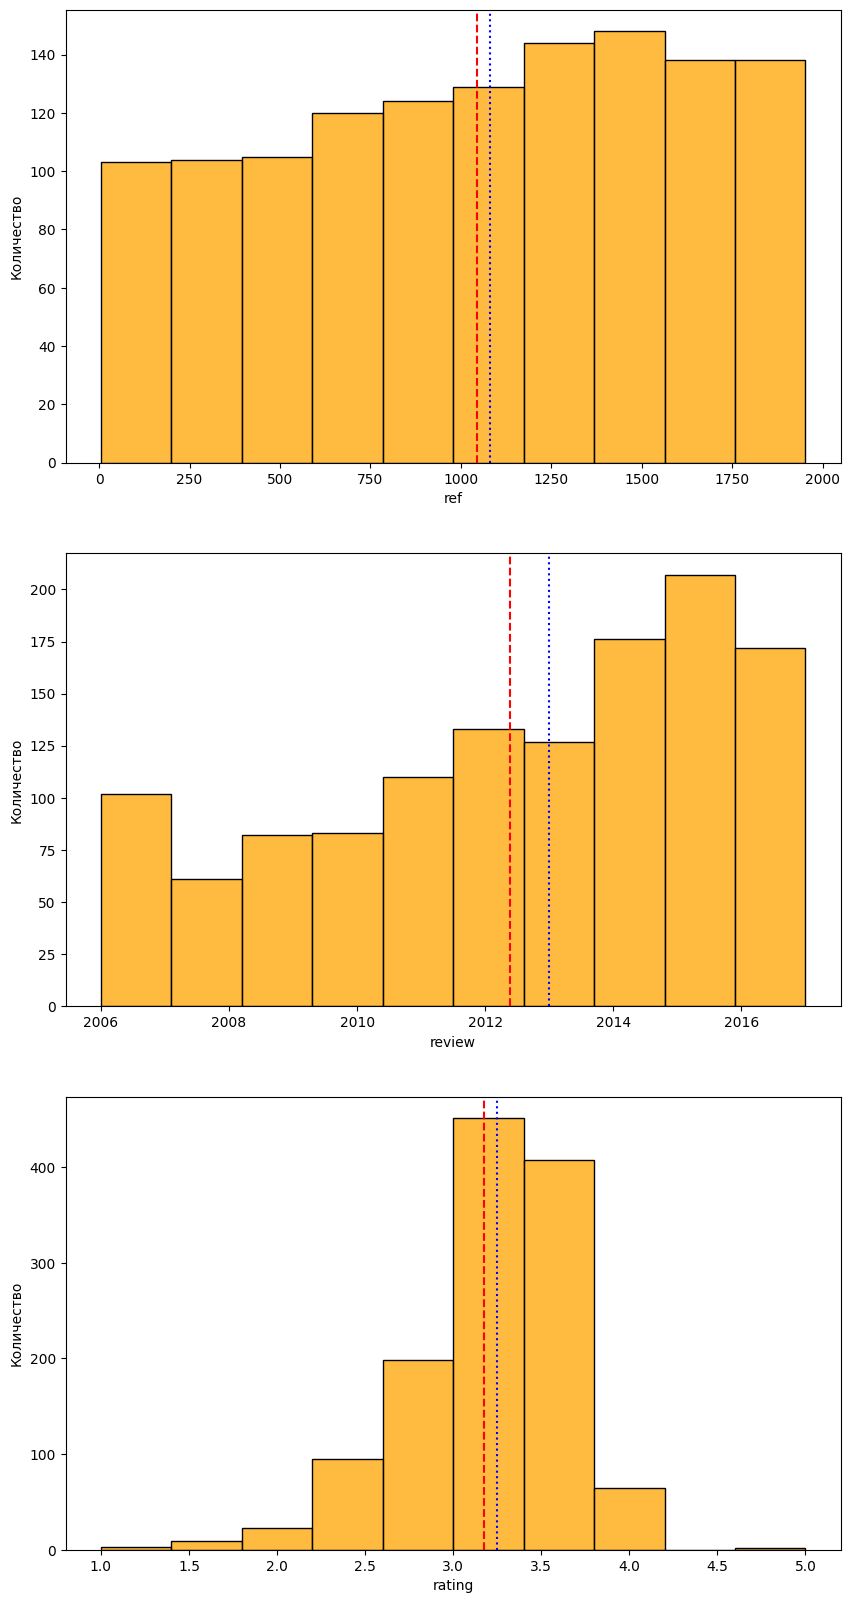

In [18]:
plot(train,num_columns_tr)

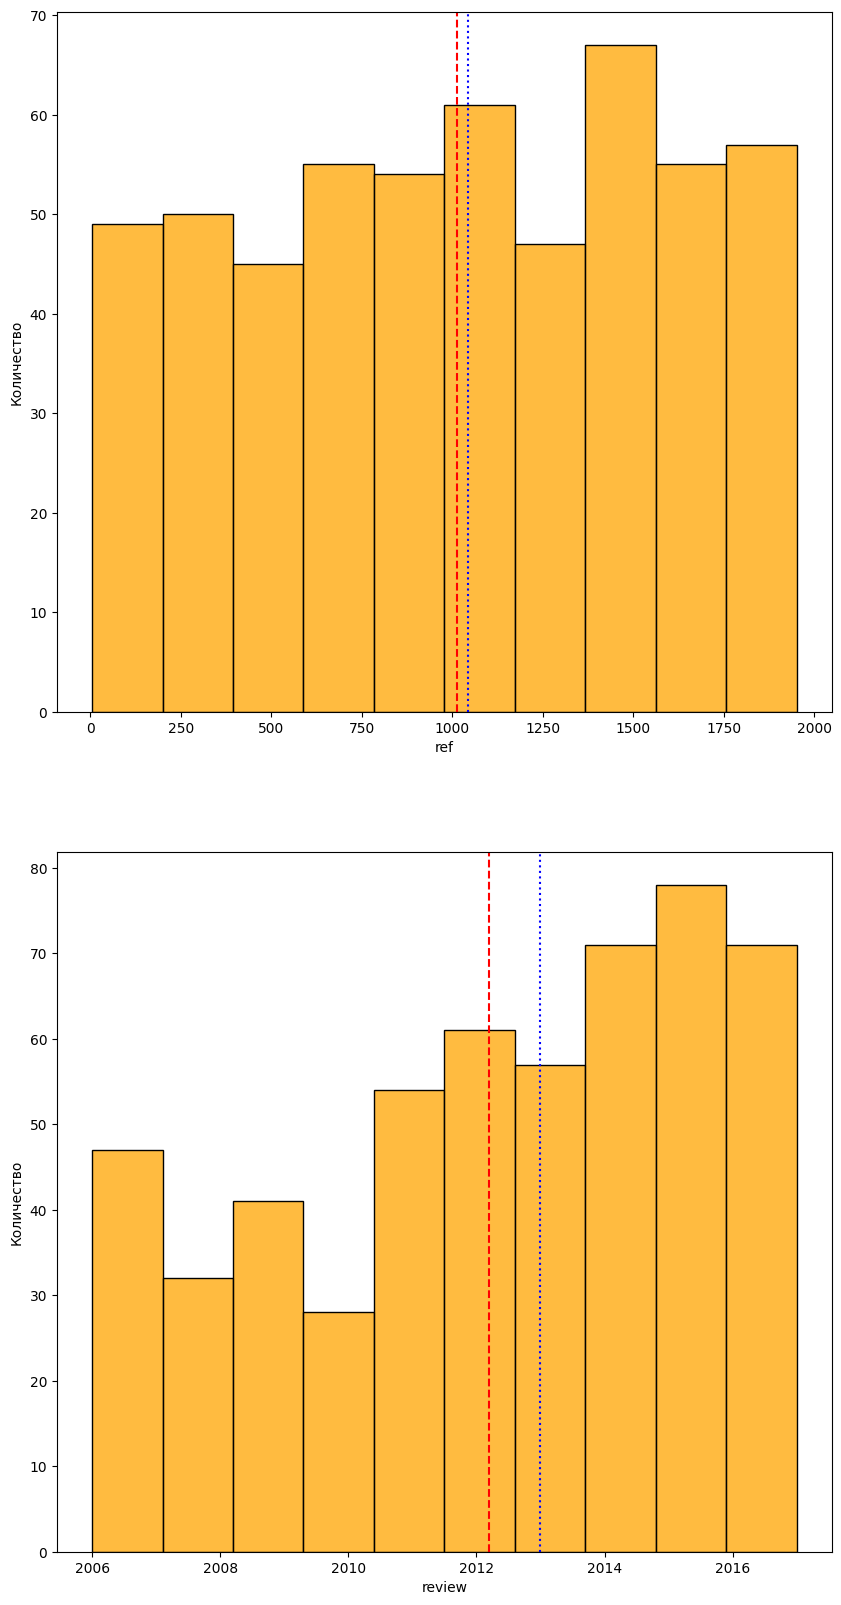

In [19]:
plot(test,num_columns_te)

* более менее похоже на нормальное распределение только rating

In [20]:
df = train.copy()
df['ref'] = np.log(df['ref'])
df['review'] = np.log(df['review'])
df['rating'] = np.log(df['rating'])

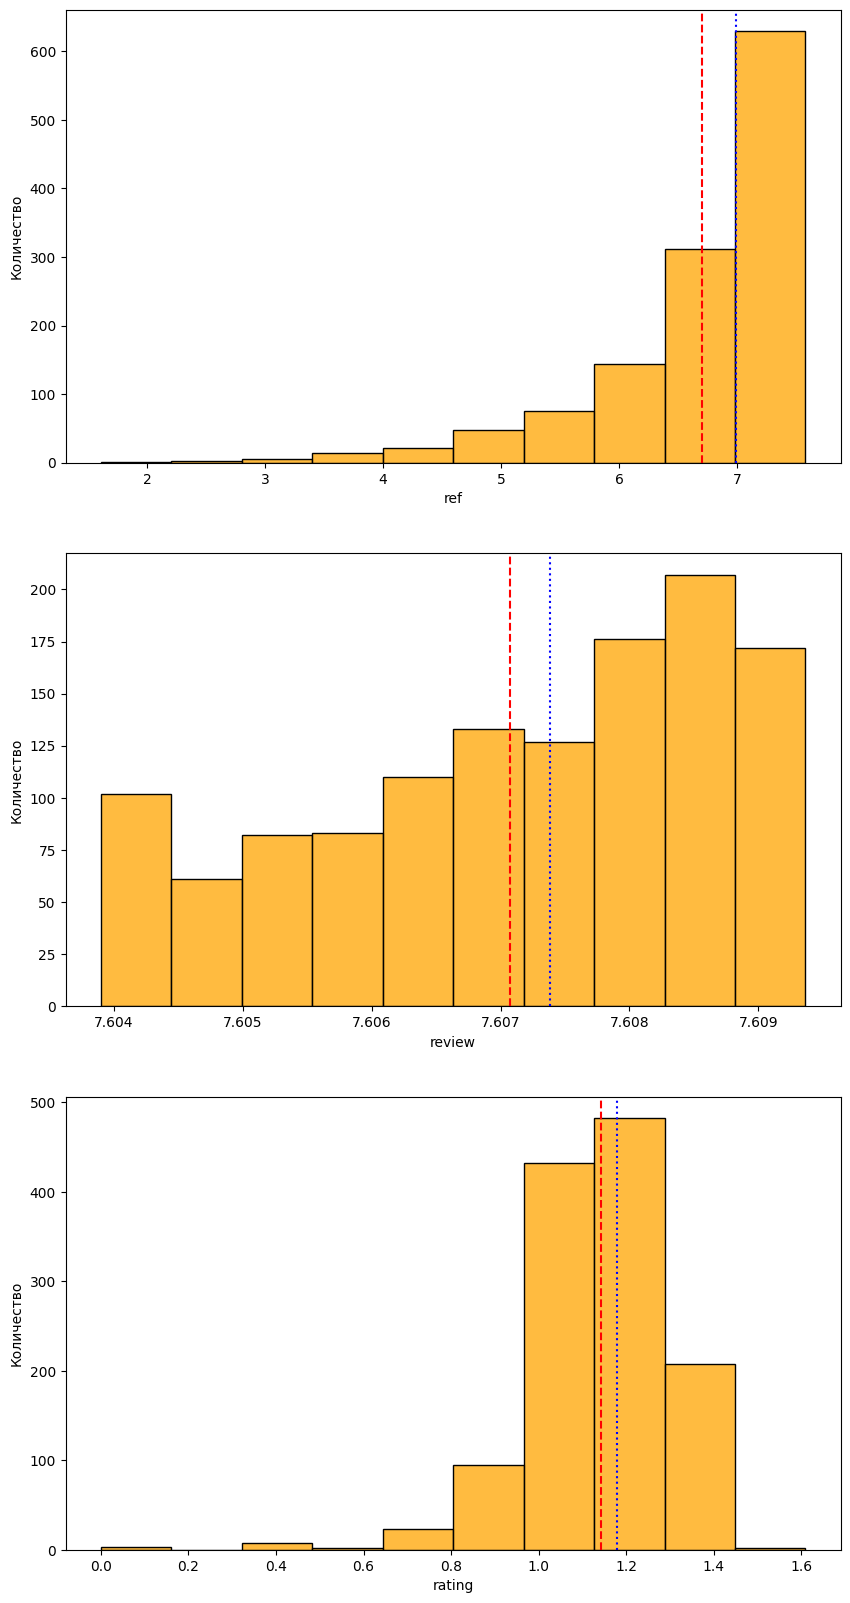

In [21]:
plot(df,num_columns_tr)

* к нормальному распредлению так и не пришли оставим все как есть.
* после логарифмирования столбец ref стал скошен влево 

In [22]:
pt = PowerTransformer(method = 'box-cox')
 
# найдем оптимальный параметр лямбда
pt.fit(train[['ref']])
 
pt.lambdas_

# преобразуем данные
bc_pt = pt.transform(train[['ref']])
 
# метод .transform() возвращает двумерный массив
bc_pt.shape

(1253, 1)

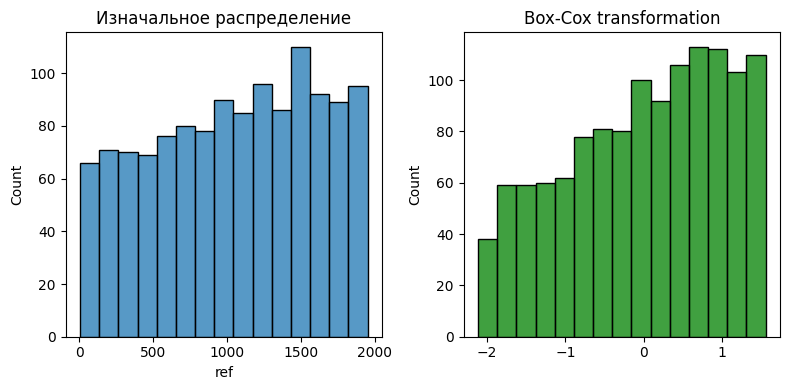

In [23]:
# сравним изначальное распределение и распределение после преобразования Бокса-Кокса
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
 
sns.histplot(x = train.ref, bins = 15, ax = ax[0])
ax[0].set_title('Изначальное распределение')
 
# так как на выходе метод .transform() выдает двумерный массив,
# его необходимо преобразовать в одномерный
sns.histplot(x = bc_pt.flatten(),
             bins = 15, color = 'green',
             ax = ax[1])
ax[1].set_title('Box-Cox transformation')
 
plt.tight_layout()
plt.show()

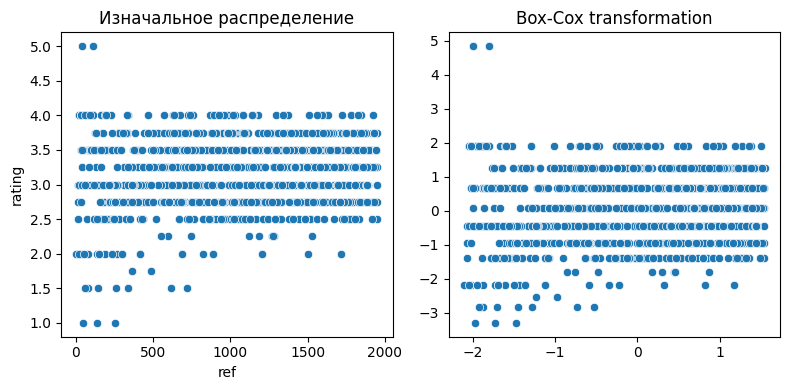

In [24]:
# оценим изменение взаимосвязи после преобразования Бокса-Кокса
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
 
sns.scatterplot(x = train.ref, y = train.rating, ax = ax[0])
ax[0].set_title('Изначальное распределение')
 
# можно использовать функцию power_transform(),
# она действует аналогично классу, но без estimator
sns.scatterplot(x = power_transform(train[['ref']], method = 'box-cox').flatten(),
                y = power_transform(train[['rating']], method = 'box-cox').flatten(),
                ax = ax[1])
ax[1].set_title('Box-Cox transformation')
 
plt.tight_layout()
 
plt.show()

In [25]:
pd.DataFrame(power_transform(train[['ref', 'rating']], method = 'box-cox'), 
             columns = [['ref', 'rating']]).corr()

,ref,rating
ref,1.000000,0.090293
rating,0.090293,1.000000


In [26]:
train[['ref','rating']].corr()

,ref,rating
ref,1.000000,0.113862
rating,0.113862,1.000000


* корреляция уменьшилась с целевой переменно после box-cox
* нормалоьного распределения опять же не получилось

Посмотрим на боксплоты

ref


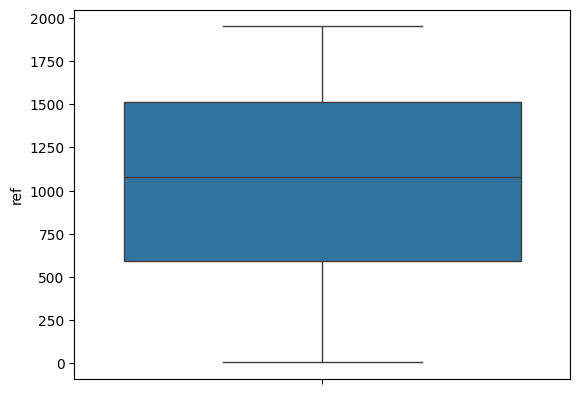

review


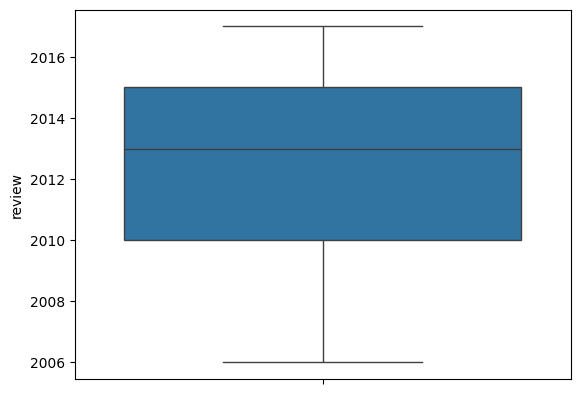

rating


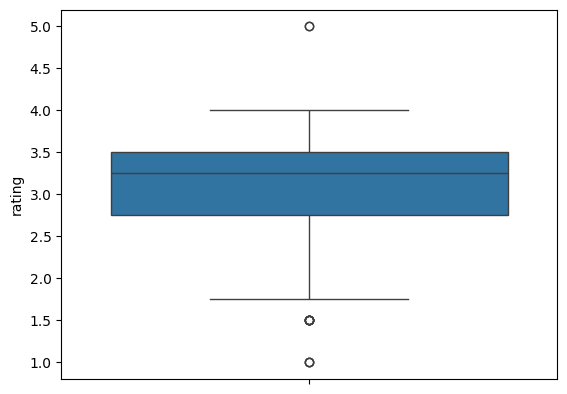

In [27]:
for col in num_columns_tr:
    print(col)
    sns.boxplot(train[col])
    plt.show()

у rating есть выбросы на они могут нам понадобится , так как это редкие значения . Оставляем их.

<Axes: >

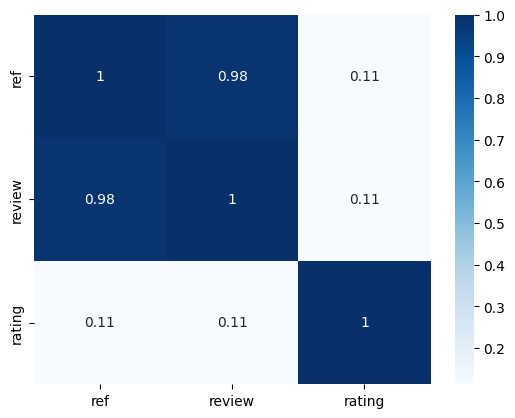

In [28]:
corr = train[num_columns_tr].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

<Axes: >

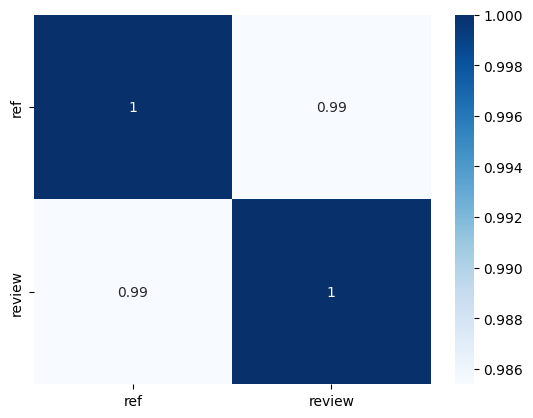

In [29]:
corr = test[num_columns_te].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

* по числовым признакам видно, что высокая корреляция у review и ref

In [30]:
train[['ref','rating']].corr()

,ref,rating
ref,1.000000,0.113862
rating,0.113862,1.000000


In [31]:
train[['review','rating']].corr()

,review,rating
review,1.00000,0.11256
rating,0.11256,1.00000


у ref корреляция повыше оставим его .

In [32]:
train = train.drop('review', axis=1)
test = test.drop('review', axis=1)

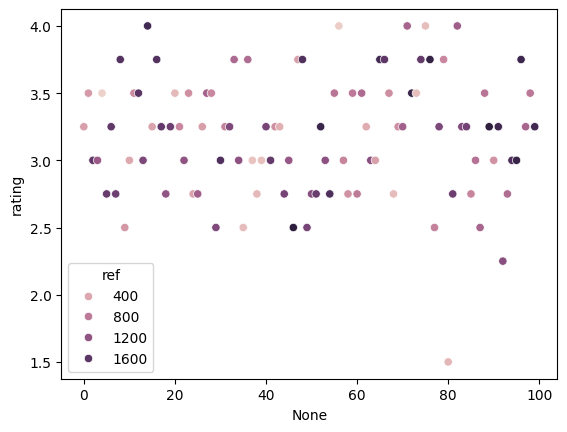

In [33]:
import seaborn as sns

sns.scatterplot(data=train.iloc[:100], x=train['ref'].iloc[:100].index, y=train['rating'].iloc[:100], hue='ref')
plt.show()

In [34]:
import association_metrics as am

XC = train.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC) 

cramersv.fit()

,company,specific_bean_origin,cocoa_percent,company_location,bean_type,broad_bean_origin
company,1.000000,0.771180,0.631741,0.999651,0.616975,0.607303
specific_bean_origin,0.771180,1.000000,0.773074,0.808513,0.907951,0.983334
cocoa_percent,0.631741,0.773074,1.000000,0.243831,0.158698,0.266361
company_location,0.999651,0.808513,0.243831,1.000000,0.291667,0.383039
bean_type,0.616975,0.907951,0.158698,0.291667,1.000000,0.388294
broad_bean_origin,0.607303,0.983334,0.266361,0.383039,0.388294,1.000000


In [35]:
import association_metrics as am

XC = test.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC) 

cramersv.fit()

,company,specific_bean_origin,cocoa_percent,company_location,bean_type,broad_bean_origin
company,1.000000,0.832175,0.773245,1.000000,0.700795,0.707739
specific_bean_origin,0.832175,1.000000,0.852083,0.875201,0.943237,0.994439
cocoa_percent,0.773245,0.852083,1.000000,0.346535,0.247606,0.391232
company_location,1.000000,0.875201,0.346535,1.000000,0.275207,0.461002
bean_type,0.700795,0.943237,0.247606,0.275207,1.000000,0.403949
broad_bean_origin,0.707739,0.994439,0.391232,0.461002,0.403949,1.000000


In [52]:
s=list(train.columns[train.dtypes == 'object'])
s.append('rating')

In [53]:
s

['company',
 'specific_bean_origin',
 'cocoa_percent',
 'company_location',
 'bean_type',
 'broad_bean_origin',
 'rating']

* company location и company, specific_bean_origin и broad_bean_origin имеют высокую корреляцию, а также у bean_type и specific_bean_origin
  

In [56]:
import association_metrics as am

XC = train[s].apply(
        lambda x: x.astype("category"))

cramersv = am.CramersV(XC) 

cramersv.fit().sort_values('rating', ascending=False)

,company,specific_bean_origin,cocoa_percent,company_location,bean_type,broad_bean_origin,rating
rating,0.592652,0.758415,0.238795,0.227641,0.158122,0.235492,1.000000
specific_bean_origin,0.771180,1.000000,0.773074,0.808513,0.907951,0.983334,0.758415
company,1.000000,0.771180,0.631741,0.999651,0.616975,0.607303,0.592652
cocoa_percent,0.631741,0.773074,1.000000,0.243831,0.158698,0.266361,0.238795
broad_bean_origin,0.607303,0.983334,0.266361,0.383039,0.388294,1.000000,0.235492
company_location,0.999651,0.808513,0.243831,1.000000,0.291667,0.383039,0.227641
bean_type,0.616975,0.907951,0.158698,0.291667,1.000000,0.388294,0.158122


если отталкиваться от корреляция к целевой переменной, то company, specific_bean_origin имеют высокую корреляцию , другие столбцы ниже.

На данный момент не будем трогать эти столбцы протестирем у моделей. Также видно, что самый важный признак для рейтинга specific_bean_origin.

# Построение новых признаков

* по данным можно заметить, что cocoa percent можно перевести в числовые значения.
* можно добавить один новый столбец со всеми текстовыми данными
* добавим булевы значения в  зав-ти от рав-ва 'broad_bean_origin' == 'specific_bean_origin' , так как географический регион происхождения и географический регион происхождения какао-бобов даже в навзвании коррелируют , а также была высокая корреляция .
* попробуем весь текст привести к нижнему регистру

In [95]:
class Feauteres:

    def __init__(self, df):
        self.df = df
    
    
    def text_add(self,df):
        text = df['company']\
    +', '+ df['specific_bean_origin']\
    +', '+ df['company_location']\
    +', '+ df['bean_type']\
    +', '+ df['broad_bean_origin']
        return text
    
    #добавление какао процента
    def per_add(self):
        self.df['cocoa_percent_float'] = self.df['cocoa_percent'].apply(lambda x: float(x[:-1])/100)

    
    def ex(self,df):
        if df['broad_bean_origin'] == df['specific_bean_origin']:
            return True
        return False

    def add_feauteres(self):
        self.per_add()
        self.df['bbo_sbo'] = self.df.apply(self.ex, axis=1)
        self.df['text'] = self.df.apply(self.text_add, axis=1)
        
        # удалим столбец cocoa_percent, так как мы его по сути дублировали

        self.df = self.df.drop('cocoa_percent', axis=1)

        # заменим заглушкой пустоту
        self.df['bean_type'] = self.df['bean_type'].apply(lambda x:x if x!='\xa0' else 'no')
        self.df['bean_type'] = self.df['bean_type'].apply(lambda x:x if x!='\xa0' else 'no')

        # приведем к нижнему регистру текст
        for i in self.df.columns[self.df.dtypes == 'object']:
            self.df[i] = self.df[i].str.lower()
        
        return self.df

In [96]:
tr = Feauteres(train)
te = Feauteres(test)
train1 = tr.add_feauteres()
test1 = te.add_feauteres()

In [97]:
train1.head()

,company,specific_bean_origin,ref,company_location,rating,bean_type,broad_bean_origin,cocoa_percent_float,bbo_sbo,text
0,willie's cacao,rio caribe,457,u.k.,3.25,trinitario,venezuela,0.72,False,"willie's cacao, rio caribe, u.k., trinitario, ..."
1,beschle (felchlin),"ocumare, premier cru, quizas no. 2",508,switzerland,3.50,no,venezuela,0.72,False,"beschle (felchlin), ocumare, premier cru, quiz..."
2,dark forest,tanzania,1554,u.s.a.,3.00,no,tanzania,0.70,True,"dark forest, tanzania, u.s.a., , tanzania"
3,brasstown aka it's chocolate,cooproagro,1125,u.s.a.,3.00,trinitario,dominican republic,0.72,False,"brasstown aka it's chocolate, cooproagro, u.s...."
4,pralus,"java, indonesie",32,france,3.50,criollo,indonesia,0.75,False,"pralus, java, indonesie, france, criollo, indo..."


# Модели

## Первая модель

In [118]:
for i in ['ref']:
    data = train1.drop([i,'rating'], axis=1)


    X_train, X_test, y_train, y_test = train_test_split(data, train['rating'], test_size=0.25, random_state=22)
    
    cols = data.columns[(data.dtypes == 'object') | (data.dtypes == 'bool')]
    cat_features=[data.columns.get_loc(c) for c in cols]
    
    model = CatBoostRegressor(cat_features=cat_features, verbose=False)
    model.fit(X_train,y_train)
    print(i)
    print('train:',r2_score(y_train, model.predict(X_train)))
    print('test:',r2_score(y_test, model.predict(X_test)))
    print('dif:', r2_score(y_test, model.predict(X_test)) - r2_score(y_train, model.predict(X_train)))
    print()
    
    for x in ['company', 'company_location']:
        data = train.drop([i,x,'rating','cocoa_percent'], axis=1)
    
    
        X_train, X_test, y_train, y_test = train_test_split(data, train1['rating'], test_size=0.25, random_state=22)
        
        cols = data.columns[(data.dtypes == 'object') | (data.dtypes == 'bool')]
        cat_features=[data.columns.get_loc(c) for c in cols]
        
        model = CatBoostRegressor(cat_features=cat_features, verbose=False)
        model.fit(X_train,y_train)
        print(i,x)
        print('train:',r2_score(y_train, model.predict(X_train)))
        print('test:',r2_score(y_test, model.predict(X_test)))
        print('dif:', r2_score(y_test, model.predict(X_test)) - r2_score(y_train, model.predict(X_train)))
        print()
        for z in ['specific_bean_origin', 'broad_bean_origin']:

            data = train.drop([z,x,i,'rating','cocoa_percent'], axis=1)


            X_train, X_test, y_train, y_test = train_test_split(data, train1['rating'], test_size=0.25, random_state=22)
            
            cols = data.columns[(data.dtypes == 'object') | (data.dtypes == 'bool')]
            cat_features=[data.columns.get_loc(c) for c in cols]
            
            model = CatBoostRegressor(cat_features=cat_features, verbose=False)
            model.fit(X_train,y_train)
            print(i,x,z)
            print('train:',r2_score(y_train, model.predict(X_train)))
            print('test:',r2_score(y_test, model.predict(X_test)))
            print('dif:', r2_score(y_test, model.predict(X_test)) - r2_score(y_train, model.predict(X_train)))
            print()

ref
train: 0.5027769680387173
test: 0.18426308185470175
dif: -0.31851388618401555

ref company
train: 0.3922706035887076
test: 0.08852364699421189
dif: -0.3037469565944957

ref company specific_bean_origin
train: 0.4074907050342951
test: 0.09669439569132376
dif: -0.3107963093429713

ref company broad_bean_origin
train: 0.39699281821614796
test: 0.09892524122779867
dif: -0.2980675769883493

ref company_location
train: 0.522360644708475
test: 0.20211369950633107
dif: -0.3202469452021439

ref company_location specific_bean_origin
train: 0.549551833578745
test: 0.21165165222077875
dif: -0.3379001813579663

ref company_location broad_bean_origin
train: 0.54145844544615
test: 0.15521406620647005
dif: -0.3862443792396799



по данным видно , что присутствует переобучение разницу r2 на трейне и тесте значительная.

после многичисленных тестов:

* с удалением только review - 0,19262%
* с удалением company сильно просаживается на 8%. Удаление категориальных столбцов не дают какого-то прироста.
* с удалением cocoa_percent и review - 0,19925%

In [98]:
# параметры модели
par ={}

In [99]:
def split_predict(train_1, param =par):
    
    X = train_1.drop(['rating'], axis=1)
    y=train_1['rating']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)
    
    cols = X.columns[(X.dtypes == 'object') | (X.dtypes == 'bool')]
    cat_features=[X.columns.get_loc(c) for c in cols]
    
    model = CatBoostRegressor(cat_features=cat_features, verbose=False,**par)
    model.fit(X_train,y_train)
    
    print('test, r2:', r2_score(y_test, model.predict(X_test)))
    print('train, r2:',r2_score(y_train, model.predict(X_train)),'\n')

    #вывод важности призакнов
    d = {'feature': model.feature_names_, 'importances': model.feature_importances_, }
    print(pd.DataFrame(d).sort_values('importances', ascending=False))

In [100]:
def save_pred(train_1, test_1,columns=[], name='pred.csv'):
    X = train_1.drop(['rating',*columns], axis=1)
    y=train_1['rating']
    
    
    cols = X.columns[(X.dtypes == 'object') | (X.dtypes == 'bool')]
    cat_features=[X.columns.get_loc(c) for c in cols]
    
    model = CatBoostRegressor(cat_features=cat_features, verbose=False,**par)
    model.fit(X,y)
    
    pred = model.predict(test_1.drop([*columns], axis=1))
    new_test = test_1.copy()
    new_test['id'] = np.arange(len(new_test))
    new_test['rating'] = pred
    #new_test['rating'] = round(new_test['rating'],2)
    new_test[['id','rating']].to_csv(name, index=False)
    new_test = new_test.drop(['id','rating'], axis=1)


    print('train, r2:',r2_score(y, model.predict(X)),'\n')

    #вывод важности призакнов
    d = {'feature': model.feature_names_, 'importances': model.feature_importances_, }
    print(pd.DataFrame(d).sort_values('importances', ascending=False))

In [44]:
split_predict(train1)

test, r2: 0.23892193182125487
train, r2: 0.48858892350507444 

                feature  importances
0               company    28.224573
6   cocoa_percent_float    26.731025
2                   ref    19.206537
4             bean_type     8.330235
3      company_location     5.158535
5     broad_bean_origin     4.835890
1  specific_bean_origin     4.317364
7               bbo_sbo     3.134224
8                  text     0.061618


In [101]:
save_pred(train1, test1,columns=[],name='new_pred.csv')

train, r2: 0.4651342541606488 

                feature  importances
0               company    29.634033
6   cocoa_percent_float    26.103772
2                   ref    19.478502
4             bean_type     9.391369
3      company_location     5.370243
1  specific_bean_origin     3.318074
5     broad_bean_origin     3.258135
7               bbo_sbo     3.161606
8                  text     0.284267


## Подбор гиперпараметров

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['company_location','broad_bean_origin','rating'], axis=1), 
                                                    train['rating'], 
                                                    test_size=0.25, 
                                                    random_state=42)

cols = X_train.columns[(X_train.dtypes == 'object') | (X_train.dtypes == 'bool')]
cat_features=[X_train.columns.get_loc(c) for c in cols]

In [115]:
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
def objective_lgbm(trial):
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1,10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1, 5)
    depth = trial.suggest_int('depth', 2, 16)

    score = cross_val_score(CatBoostRegressor(cat_features=cat_features, 
                                              verbose=False,
                                              min_data_in_leaf = min_data_in_leaf,
                                              learning_rate=learning_rate, 
                                              n_estimators=n_estimators,
                                              l2_leaf_reg=l2_leaf_reg,
                                              depth = depth),
                            X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective_lgbm, n_trials=1000)

[I 2023-12-28 01:51:29,508] A new study created in memory with name: no-name-41875ba5-47ed-46fd-8904-64c7532d5c06
[I 2023-12-28 01:54:00,491] Trial 0 finished with value: 0.08536648329302658 and parameters: {'min_data_in_leaf': 4, 'learning_rate': 0.0028689707388023745, 'n_estimators': 853, 'l2_leaf_reg': 1.5118098136768872, 'depth': 14}. Best is trial 0 with value: 0.08536648329302658.
[I 2023-12-28 01:54:03,640] Trial 1 finished with value: 0.052588284678313335 and parameters: {'min_data_in_leaf': 4, 'learning_rate': 0.0004495901680836608, 'n_estimators': 982, 'l2_leaf_reg': 1.2618499497479263, 'depth': 6}. Best is trial 0 with value: 0.08536648329302658.
[I 2023-12-28 01:54:04,681] Trial 2 finished with value: 0.14338945371656575 and parameters: {'min_data_in_leaf': 1, 'learning_rate': 0.03949849637125452, 'n_estimators': 369, 'l2_leaf_reg': 4.438800155171794, 'depth': 3}. Best is trial 2 with value: 0.14338945371656575.
[I 2023-12-28 01:54:06,102] Trial 3 finished with value: 0.141

In [110]:
par ={'min_data_in_leaf': 3,
 'learning_rate': 0.017218508713245248,
 'n_estimators': 649,
 'l2_leaf_reg': 1.8741858854421163,
 'depth': 3}

In [ ]:
save_pred(train1, test1,columns=[],name='new_pred.csv')

kaggle 0,21302

## другие тесты

### тест2.1

* удалим столбцы
* создадим одинс толбец со всем текстом
* попробуемв векторизовать столбец

делаем векторизацию с помощью countvectorized и с maxabsscaller

### тест 2.2 countvectorized

In [189]:
mystem_analyzer = Mystem(entire_input=False)

In [190]:
# создаем множества стопслов русских и пунктуации
stop_words = set(stopwords.words('russian'))
stop_punct = set(punctuation+'«'+'»'+'—')
words_english = set(stopwords.words("english"))

noise = list(set.union(stop_punct,words_english))

In [235]:
def test_cv(train_2, mode =4,drop=False)->None:
    mystem_analyzer = Mystem(entire_input=False)
    if drop:
        train_2 = train_2.drop(['bbo_sbo'], axis=1)
    
    X = train_2.drop(['rating'], axis=1)
    y = train_2['rating']

    #разбиение на тест/трейн
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)
    
    for min_df in range(1,4,1):
        for ngram in range(1,4,1):
    
            
            vec = CountVectorizer(max_df=1.0,min_df=min_df,ngram_range=(1,ngram), 
                                  tokenizer=mystem_analyzer.lemmatize ,
                                  token_pattern=None,stop_words=noise)
    
            #векторизация числовых данных
            bow_total = csr_matrix(X_train[X_train.columns[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')]])
            bow_total_test = csr_matrix(X_test[X_train.columns[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')]])
    
            #векторизация категориальных значений
            for column in X_train.drop(X_train.columns[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')], axis=1).columns:
                vec.fit(X_train[column])
                bow = vec.transform(X_train[column])  # bow — bag of words (мешок слов)
                bow_test = vec.transform(X_test[column])
            
                bow_total = hstack((bow,bow_total))
                bow_total_test = hstack((bow_test,bow_total_test))
        
            if mode ==1:
                model = GradientBoostingRegressor(verbose=False)#,**par)
            if mode == 2:
                model = XGBRegressor()#,**par)
            if mode == 3:
                model = LGBMRegressor()#,**par)
            if mode == 4:
                model = CatBoostRegressor(verbose=False,**par)
            
            model.fit(bow_total, y_train)
            
            pred = model.predict(bow_total_test)
            print('min:',min_df,'ngram:',ngram)
            print(r2_score(y_test, pred))

In [236]:
for i in range(1,5):
    print(i)
    test_cv(train1,mode=i,drop=True)
    print()

1
min: 1 ngram: 1
0.1681155489131284
min: 1 ngram: 2
0.1711975927514352
min: 1 ngram: 3
0.15795594237128951
min: 2 ngram: 1
0.18446965405429572
min: 2 ngram: 2
0.18414180819010584
min: 2 ngram: 3
0.18316907592953668
min: 3 ngram: 1
0.1911217871755284
min: 3 ngram: 2
0.1769541748629586
min: 3 ngram: 3
0.1698058307488307

2
min: 1 ngram: 1
0.19699388364565584
min: 1 ngram: 2
0.17984508336092908
min: 1 ngram: 3
0.1760798904420876
min: 2 ngram: 1
0.19468736590647007
min: 2 ngram: 2
0.18194795674411812
min: 2 ngram: 3
0.19951709930499018
min: 3 ngram: 1
0.20314158171045316
min: 3 ngram: 2
0.14322818324816788
min: 3 ngram: 3
0.16197754169166922

3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 939, number of used features: 87


интересно, в этих тестах наилучший рез-ат оказался у XGBRegressor с мин 3 , и с 1 нграммой.

### тест 2.3 tfidf и пайплайн

* tfidf
* другие модели для обчуения протестим

In [239]:
def test_tfidf(train_2, drop=False, mode=1)->None:
    mystem_analyzer = Mystem(entire_input=False)

    if drop:
        train_2 = train_2.drop(['bbo_sbo'], axis=1)
    
    X = train_2.drop(['rating'], axis=1)
    y = train_2['rating']

    #разбиение на тест/трейн
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)
    
    for min_df in range(1,4,1):
        for ngram in range(1,4,1):
    
            
            vec = TfidfVectorizer(max_df=1.0,min_df=min_df,ngram_range=(1,ngram), 
                                  tokenizer=mystem_analyzer.lemmatize ,
                                  token_pattern=None,stop_words=noise)
    
            #векторизация числовых данных
            bow_total = csr_matrix(X_train[X_train.columns[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')]])
            bow_total_test = csr_matrix(X_test[X_train.columns[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')]])
    
            #векторизация категориальных значений
            for column in X_train.drop(X_train.columns[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')], axis=1).columns:
                #print(column)
                vec.fit(X_train[column])
                bow = vec.transform(X_train[column])  # bow — bag of words (мешок слов)
                bow_test = vec.transform(X_test[column])
            
                bow_total = hstack((bow,bow_total))
                bow_total_test = hstack((bow_test,bow_total_test))

            if mode ==1:
                model = GradientBoostingRegressor(verbose=False)#,**par)
            if mode == 2:
                model = XGBRegressor()#,**par)
            if mode == 3:
                model = LGBMRegressor()#,**par)
            if mode == 4:
                model = CatBoostRegressor(verbose=False,**par)
            model.fit(bow_total, y_train)
            
            pred = model.predict(bow_total_test)
            print('min:',min_df,'ngram:',ngram)
            print(r2_score(y_test, pred))

In [238]:
for i in range(1,5):
    print(i)
    test_tfidf(train1,drop=True,mode=i)
    print()

1
min: 1 ngram: 1
0.1585377384019665
min: 1 ngram: 2
0.20522265814819496
min: 1 ngram: 3
0.20020584976886913
min: 2 ngram: 1
0.17810050628024898
min: 2 ngram: 2
0.20664472557627367
min: 2 ngram: 3
0.19969649241917609
min: 3 ngram: 1
0.17018794382666735
min: 3 ngram: 2
0.16338437499821834
min: 3 ngram: 3
0.16209810130835112

2
min: 1 ngram: 1
0.11398242669583547
min: 1 ngram: 2
0.13117907498747927
min: 1 ngram: 3
0.13201571072058138
min: 2 ngram: 1
0.13948207289782066
min: 2 ngram: 2
0.17774761278426898
min: 2 ngram: 3
0.17074703413147674
min: 3 ngram: 1
0.12859027661658984
min: 3 ngram: 2
0.09882389348433251
min: 3 ngram: 3
0.10598008072073495

3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 939, number of used feature

In [240]:
# со стоп словами
for i in range(1,5):
    print(i)
    test_tfidf(train1,drop=True,mode=i)
    print()

1
min: 1 ngram: 1
0.16217828582352234
min: 1 ngram: 2
0.17456522421969256
min: 1 ngram: 3
0.1911786476080699
min: 2 ngram: 1
0.19560426640606876
min: 2 ngram: 2
0.21946669597454782
min: 2 ngram: 3
0.2193018398392892
min: 3 ngram: 1
0.16679056511364188
min: 3 ngram: 2
0.1794227853105389
min: 3 ngram: 3
0.17362609044455346

2
min: 1 ngram: 1
0.056421509665660396
min: 1 ngram: 2
0.10037856602314399
min: 1 ngram: 3
0.12755601140312733
min: 2 ngram: 1
0.1540268712330931
min: 2 ngram: 2
0.1381574384461035
min: 2 ngram: 3
0.12288332417032188
min: 3 ngram: 1
0.08515867584698555
min: 3 ngram: 2
0.10260531333919665
min: 3 ngram: 3
0.12540725464923896

3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1321
[LightGBM] [Info] Number of data points in the train set: 939, number of used features: 

GradientBoostingRegressor показал лучшие ре-ты с tfidf. мин 2 , нграм 3, со стоп словами рез-ат улучшился. Но сами рез-ты стали хуже , чем без векторизации текстов.

In [357]:
train2 = train1.copy()
test2= test1.copy()

In [340]:
train2['bbo_sbo'] = train2['bbo_sbo'].apply(lambda x: 1 if x==True else 0)
test2['bbo_sbo'] = test2['bbo_sbo'].apply(lambda x: 1 if x==True else 0)

In [346]:
X = train2.drop(['rating'], axis=1)
y=train2['rating']

mystem_analyzer = Mystem(entire_input=False)

vec = TfidfVectorizer(max_df=1.0,min_df=2,ngram_range=(1,3), 
                      tokenizer=mystem_analyzer.lemmatize ,
                      token_pattern=None,stop_words=noise)

#векторизация числовых данных
bow_total = csr_matrix(X[X.columns[(X.dtypes == 'int64') | (X.dtypes == 'float64')]])
bow_total_test = csr_matrix(test2[test2.columns[(test2.dtypes == 'int64') | (test2.dtypes == 'float64')]])

#векторизация категориальных значений
for column in X.drop(X.columns[(X.dtypes == 'int64') | (X.dtypes == 'float64')], axis=1).columns:
    #print(column)
    vec.fit(X[column])
    bow = vec.transform(X[column])  # bow — bag of words (мешок слов)
    bow_test = vec.transform(test2[column])

    bow_total = hstack((bow,bow_total))
    bow_total_test = hstack((bow_test,bow_total_test))

model = GradientBoostingRegressor(verbose=False)

model.fit(bow_total, y)

pred = model.predict(bow_total_test)
new_test = test1.copy()
new_test['id'] = np.arange(len(new_test))
new_test['rating'] = pred
#new_test['rating'] = round(new_test['rating'],2)
new_test[['id','rating']].to_csv('gbr.csv', index=False)
new_test = new_test.drop(['id','rating'], axis=1)


print('train, r2:',r2_score(y, model.predict(bow_total)),'\n')

#вывод важности призакнов
#d = {'feature': model.feature_names_, 'importances': model.feature_importances_, }
#print(pd.DataFrame(d).sort_values('importances', ascending=False))

train, r2: 0.4512767218625001 



* 0,12557

In [358]:
train2 = train1.copy()
test2= test1.copy()

In [359]:
X = train2.drop(['rating'], axis=1)
y=train2['rating']


cols = X.columns[(X.dtypes == 'object') | (X.dtypes == 'bool')]
cat_features=[X.columns.get_loc(c) for c in cols]

In [360]:
from sklearn.pipeline import Pipeline
from category_encoders.ordinal import OrdinalEncoder 
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder 
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import StandardScaler
p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cols)), 
    ('scaler_', StandardScaler()),
    ('model_', GradientBoostingRegressor(verbose=False))
    ])

In [361]:
p1.fit(X, y)

Pipeline(steps=[('encoder_',
                 TargetEncoder(cols=Index(['company', 'specific_bean_origin', 'company_location', 'bean_type',
       'broad_bean_origin', 'bbo_sbo', 'text'],
      dtype='object'))),
                ('scaler_', StandardScaler()),
                ('model_', GradientBoostingRegressor(verbose=False))])

In [362]:
pred = p1.predict(test2)

In [364]:
new_test = test1.copy()
new_test['id'] = np.arange(len(new_test))
new_test['rating'] = pred
#new_test['rating'] = round(new_test['rating'],2)
new_test[['id','rating']].to_csv('gbr1.csv', index=False)
new_test = new_test.drop(['id','rating'], axis=1)


print('train, r2:',r2_score(y, p1.predict(X)),'\n')

train, r2: 0.9821756726601542 



мы словили переообчение.

* Score: 0.03297

In [370]:
p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cols)), 
    ('scaler_', StandardScaler()),
    ('model_', XGBRegressor())
    ])

In [371]:
p1.fit(X, y)

Pipeline(steps=[('encoder_',
                 TargetEncoder(cols=Index(['company', 'specific_bean_origin', 'company_location', 'bean_type',
       'broad_bean_origin', 'bbo_sbo', 'text'],
      dtype='object'))),
                ('scaler_', StandardScaler()),
                ('model_',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              e...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [372]:
pred = p1.predict(test2)
new_test = test1.copy()
new_test['id'] = np.arange(len(new_test))
new_test['rating'] = pred
#new_test['rating'] = round(new_test['rating'],2)
new_test[['id','rating']].to_csv('gbr1.csv', index=False)
new_test = new_test.drop(['id','rating'], axis=1)


print('train, r2:',r2_score(y, p1.predict(X)),'\n')

train, r2: 0.9997900290267785 



опять переообучение.

In [375]:
p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cols)), 
    ('scaler_', StandardScaler()),
    ('model_', LGBMRegressor())
    ])

In [376]:
p1.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 1253, number of used features: 9
[LightGBM] [Info] Start training from score 3.176377


Pipeline(steps=[('encoder_',
                 TargetEncoder(cols=Index(['company', 'specific_bean_origin', 'company_location', 'bean_type',
       'broad_bean_origin', 'bbo_sbo', 'text'],
      dtype='object'))),
                ('scaler_', StandardScaler()), ('model_', LGBMRegressor())])

In [377]:
pred = p1.predict(test2)
new_test = test1.copy()
new_test['id'] = np.arange(len(new_test))
new_test['rating'] = pred
#new_test['rating'] = round(new_test['rating'],2)
new_test[['id','rating']].to_csv('gbr1.csv', index=False)
new_test = new_test.drop(['id','rating'], axis=1)


print('train, r2:',r2_score(y, p1.predict(X)),'\n')

train, r2: 0.9754084805553802 



* огромное переобьучние модели , как вариант можно уменгшить кол-во прищнаков.

### попробуем агрегацию

In [225]:
def features_add(df,col,colagg ='ref'):
    z = ' r '
    if colagg =='cocoa_percent_float':
        z = ' cpf '
    comp_loc_avg= df.groupby(col).agg({colagg:['min','max','median']}).fillna(0)
    comp_loc_avg.columns = comp_loc_avg.columns.droplevel(0)
    comp_loc_avg=comp_loc_avg.reset_index()\
    #.rename(columns={'min':col+z+' min','max':col+z+' max','median':col+z+' median','std':col+z+' std'})
    df = df.merge(comp_loc_avg, on=col)

    return df

In [248]:
tr = features_add(train1,'company')
te = features_add(test1,'company')

In [246]:
split_predict(tr)

test, r2: 0.24287896560156508
train, r2: 0.4697951440085816 

                 feature  importances
6    cocoa_percent_float    24.730293
0                company    20.380191
2                    ref    13.282362
10                   max     7.309364
4              bean_type     6.926140
9                    min     6.752330
3       company_location     4.904341
1   specific_bean_origin     4.753197
11                median     3.879419
5      broad_bean_origin     3.724391
7                bbo_sbo     3.357972
8                   text     0.000000


In [249]:
save_pred(tr, te,columns=[],name='agg_pred.csv')

train, r2: 0.4779517009330032 

                 feature  importances
0                company    24.843477
6    cocoa_percent_float    23.705981
2                    ref    15.025212
10                   max     7.951846
4              bean_type     6.831007
9                    min     5.873642
3       company_location     3.452698
11                median     3.440249
5      broad_bean_origin     3.268013
7                bbo_sbo     3.144637
1   specific_bean_origin     2.463237
8                   text     0.000000


* на трейн /тестах становится только хуже после агрегации. r2 стал минусовой.
* на kaggle тоже

### тест 3

* поработать еще с текстом , возможно поудалять столбцы
* попробовать другие модели
* посмотреть распределение целевой переменной

In [251]:
'sds d.d sds'.replace('.','')

'sds dd sds'

#### попробуем с подсчетом слов

In [263]:
tr = train1.copy()
te = test1.copy()

In [253]:
tr['text_count'] = tr['text'].apply( lambda x: len(x.split(',')))
te['text_count'] = te['text'].apply( lambda x: len(x.split(',')))

In [254]:
save_pred(tr, te,columns=[], name= 'lower_count.csv')

train, r2: 0.45788362031178753 

                 feature  importances
0                company    30.031003
7    cocoa_percent_float    21.282098
2                    ref    16.677096
5              bean_type     7.919280
10            text_count     6.149195
3          cocoa_percent     5.008343
4       company_location     4.219128
6      broad_bean_origin     3.293134
1   specific_bean_origin     3.088444
8                bbo_sbo     2.076388
9                   text     0.255891


* подсчет кол-во слов - не дает улучшения .

#### попробуем заменить точки на ''

In [287]:
tr = train1.copy()
te = test1.copy()

In [288]:
for i in tr.columns[tr.dtypes == 'object']:
    tr[i] = tr[i].apply( lambda x: x.replace('.',''))
    te[i] = te[i].apply( lambda x: x.replace('.',''))

In [289]:
save_pred(tr, te,columns=[], name= 'wo_t.csv')

train, r2: 0.4651342541606488 

                feature  importances
0               company    29.634033
6   cocoa_percent_float    26.103772
2                   ref    19.478502
4             bean_type     9.391369
3      company_location     5.370243
1  specific_bean_origin     3.318074
5     broad_bean_origin     3.258135
7               bbo_sbo     3.161606
8                  text     0.284267


* никак не изменился. 0,21302

#### попробуем с чистой лематизацией

In [119]:
mystem_analyzer = Mystem(entire_input=False)

In [290]:
train_2 = train1.copy()
test_2 = test1.copy()

In [133]:
for i in train_2.columns[train_2.dtypes == 'object']:
    train_2[i] = train_2[i].apply( lambda x: ' '.join(mystem_analyzer.lemmatize(x)))

In [134]:
for i in test_2.columns[test_2.dtypes == 'object']:
    test_2[i] = test_2[i].apply( lambda x: ' '.join(mystem_analyzer.lemmatize(x)))

In [137]:
save_pred(train_2, test_2,columns=[], name= 'lower_lema.csv')

* ухудшилось

#### попробуем почистить от стоп слов

In [291]:
def token_lema(stroka):
    # получаем данные
    example=word_tokenize(stroka)
    
    # создаем множества стопслов русских и пунктуации
    #stop_words = set(stopwords.words('russian'))
    stop_punct = set(punctuation+'«'+'»'+'—')
    #words_english = set(stopwords.words("english"))
    #print(example)
    noise = set.union(stop_punct,words_english)

    # фильтруем убирая стопслова
    filtered_tokens_punct_rus = [word for word in stroka.split() if word not in noise]

    #print(filtered_tokens_punct_rus)
    #проверяем isalpha() алфовитные символы в строке

    #print(spisok)
    #начинаем лематизацию
    #mystem_analyzer = Mystem(entire_input=False)
    
    #spisok=''
    #for i in texts_tokenized:
    #    spisok+=i+' '
    
    #получаем список
    #example_lema = mystem_analyzer.lemmatize(stroka)
    texts_tokenized = [
        t for t in filtered_tokens_punct_rus if t.isalpha()
    ]
    spisok= " ".join(filtered_tokens_punct_rus)
    
    return spisok

In [292]:
train_noise = train1.copy()
test_noise = test1.copy()

In [293]:
for i in train_noise.columns[train_noise.dtypes == 'object']:
    train_noise[i] = train_noise[i].apply(token_lema)
for i in test_noise.columns[test_noise.dtypes == 'object']:
    test_noise[i] = test_noise[i].apply(token_lema)
save_pred(train_noise, test_noise,columns=[], name= 'lower_ltoken_isal.csv')

train, r2: 0.4651342541606488 

                feature  importances
0               company    29.634033
6   cocoa_percent_float    26.103772
2                   ref    19.478502
4             bean_type     9.391369
3      company_location     5.370243
1  specific_bean_origin     3.318074
5     broad_bean_origin     3.258135
7               bbo_sbo     3.161606
8                  text     0.284267


In [294]:
for i in test_noise.columns[test_noise.dtypes == 'object']:
    test_noise[i] = test_noise[i].apply(token_lema)

In [295]:
save_pred(train_noise, test_noise,columns=[], name= 'lower_ltoken_isal.csv')

train, r2: 0.4651342541606488 

                feature  importances
0               company    29.634033
6   cocoa_percent_float    26.103772
2                   ref    19.478502
4             bean_type     9.391369
3      company_location     5.370243
1  specific_bean_origin     3.318074
5     broad_bean_origin     3.258135
7               bbo_sbo     3.161606
8                  text     0.284267


* 0,20803 ухудшилось

#### без isalpha

In [296]:
train_noise = train1.copy()
test_noise = test1.copy()

In [297]:
for i in train_noise.columns[train_noise.dtypes == 'object']:
    train_noise[i] = train_noise[i].apply(token_lema)
for i in test_noise.columns[test_noise.dtypes == 'object']:
    test_noise[i] = test_noise[i].apply(token_lema)
save_pred(train_noise, test_noise,columns=[], name= 'lower_ltoken_isal.csv')

train, r2: 0.4651342541606488 

                feature  importances
0               company    29.634033
6   cocoa_percent_float    26.103772
2                   ref    19.478502
4             bean_type     9.391369
3      company_location     5.370243
1  specific_bean_origin     3.318074
5     broad_bean_origin     3.258135
7               bbo_sbo     3.161606
8                  text     0.284267


* хуже

#### тест без выбросов по y

rating


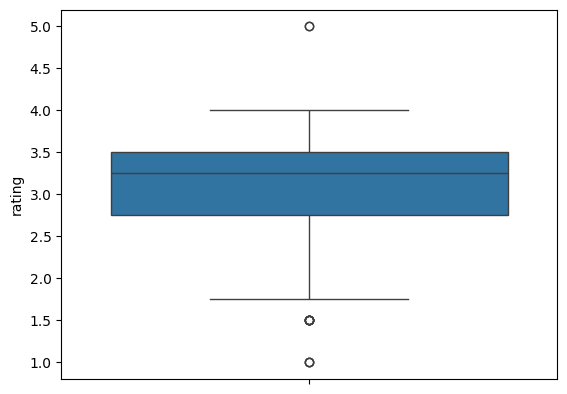

cocoa_percent_float


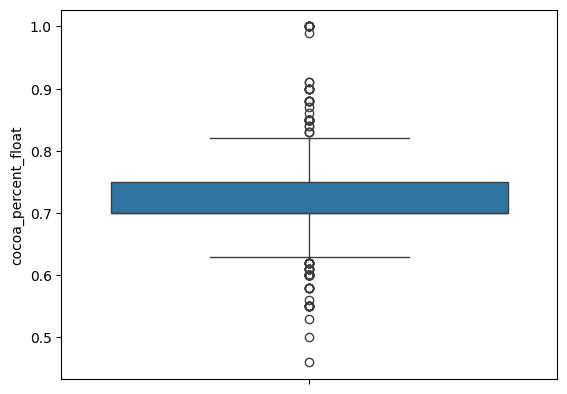

In [303]:
for col in train1.columns[train1.dtypes =='float']:
    print(col)
    sns.boxplot(train1[col])
    plt.show()

In [304]:
train_2 = train1[(train1['rating'] > 1)&(train1['rating'] < 5)]

In [305]:
save_pred(train_2, test1, name= 'drop_y.csv')

train, r2: 0.4467718046300231 

                feature  importances
0               company    31.342345
6   cocoa_percent_float    27.674872
2                   ref    15.751308
4             bean_type     7.060019
5     broad_bean_origin     5.276704
3      company_location     5.208819
7               bbo_sbo     4.070868
1  specific_bean_origin     3.615066
8                  text     0.000000


* дропать y не стоит одни из важных параметров

Выводы тестов , которые были проведены, но не дали рез-та.

* логарифирование с последующим экспонентой по y дало ухудшение метрики на тесте
* логарифмирование по всем столбца крое y дало резат 0.20143% на данный момент лучший
* все столбцы и y после логарифмирования дают худший рез-ат 18%

### тесты 4

* логарифирование с последующим экспонентой по y дало ухудшение метрики на тесте
* все столбцы и y после логарифмирования дают худший рез-ат 18%

In [328]:
tr =train1.copy()
te =test1.copy()

In [329]:
tr['ref'] = np.log(tr['ref'])
te['ref'] = np.log(te['ref'])
tr['cocoa_percent_float'] = np.log(tr['cocoa_percent_float'])
te['cocoa_percent_float'] = np.log(te['cocoa_percent_float'])

In [330]:
save_pred(tr, te,columns=[],name='log.csv')

train, r2: 0.49227676086579997 

                feature  importances
6   cocoa_percent_float    29.254654
0               company    25.588912
2                   ref    23.828971
4             bean_type     8.806649
3      company_location     3.957537
5     broad_bean_origin     2.824323
1  specific_bean_origin     2.821312
7               bbo_sbo     2.614044
8                  text     0.303598


* увеличился рез-ат до 0.21345.

In [390]:
tr

,company,specific_bean_origin,ref,company_location,rating,bean_type,broad_bean_origin,cocoa_percent_float,bbo_sbo,text
0,willie's cacao,rio caribe,457,u.k.,3.25,trinitario,venezuela,72.0,False,"willie's cacao, rio caribe, u.k., trinitario, ..."
1,beschle (felchlin),"ocumare, premier cru, quizas no. 2",508,switzerland,3.50,no,venezuela,72.0,False,"beschle (felchlin), ocumare, premier cru, quiz..."
2,dark forest,tanzania,1554,u.s.a.,3.00,no,tanzania,70.0,True,"dark forest, tanzania, u.s.a., , tanzania"
3,brasstown aka it's chocolate,cooproagro,1125,u.s.a.,3.00,trinitario,dominican republic,72.0,False,"brasstown aka it's chocolate, cooproagro, u.s...."
4,pralus,"java, indonesie",32,france,3.50,criollo,indonesia,75.0,False,"pralus, java, indonesie, france, criollo, indo..."
...,...,...,...,...,...,...,...,...,...,...
1248,artisan du chocolat,madagascar,363,u.k.,3.00,"criollo, trinitario",madagascar,80.0,True,"artisan du chocolat, madagascar, u.k., criollo..."
1249,marana,cusco,1884,peru,2.75,no,peru,70.0,False,"marana, cusco, peru, , peru"
1250,arete,nacional,1534,u.s.a.,3.50,forastero (nacional),peru,68.0,False,"arete, nacional, u.s.a., forastero (nacional),..."
1251,fresco,"conacado, #212, lr, sc",642,u.s.a.,3.50,no,dominican republic,72.0,False,"fresco, conacado, #212, lr, sc, u.s.a., , dom..."


# Выводы

* лучший рез-ат у катбуста
* добавлние пар-ов по агрегации не дало рез-ат
* прирост дали параметры суммы всех текстов , 
удаления года, 
добавлние булева значения между двумя колонками specific_bean_origin и broad_bean_origin,
изменения данных cocoa_percent на тип float
* удаление выбросов не дает улчшения модели , если они значительны
* замена пропусков не всегда дает рез-ат
* приведение к нижнему регистру всех текстов увеличило скор 
* логарифмирование числовых данных незначительно, но также увеличило скор.
